<a href="https://colab.research.google.com/github/reinereng/DNC/blob/main/Desafio%2006/Desafio_06_Churn_em_Streaming.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Preveja os usuários com alta chance de deixar seu _Streaming_**

Desafio 05 do curso de Formação de Dados da DNC. O foco desta atividade é utilizar um modelo de classificação para mapear qual o perfil de
usuários tem mais chance de deixar sua plataforma de _streaming_.

---

# **ETAPA 1: BUSINESS UNDERSTANDING**

## **Contexto**

A diretoria, de uma plataforma de *streaming*, está preocupada com o alto índice de usuários cancelando as suas assinaturas. Eles acreditam que é possível prever se um usuário tem mais chance de deixar a plataforma antes que isso aconteça, e com base nessa informação tomar ações para reduzir o churn.

Seu objetivo é criar um modelo de classificação capaz de prever se um usuário tem mais chance de cancelar a sua assinatura na plataforma ou não. Para isso, a empresa forneceu uma base de dados em csv contendo dados sobre as contas dos clientes.

In [ ]:
!pip install pandas-profiling==3.3.0
!pip install sidetable

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import sidetable
import pandas_profiling
import missingno as msno
from ipywidgets import interact, widgets

from sklearn import datasets
from sklearn.preprocessing import scale, minmax_scale, power_transform

/usr/local/lib/python3.10/dist-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/usr/local/lib/python3.10/dist-packages/visions/backends/shared/nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:


# **ETAPA 2: DATA UNDESTANDING**

Os dados são Uma adaptação do problema de ecommerce, disponível no Kaggle, e possuem informações sobre as contas dos clientes na plataforma
de streaming, divididos entre contas Basic, Standard e Premium, onde cada uma oferece uma gama maior de serviços que a anterior

|Coluna | Descrição | Tipo
--- | --- | ---
client_id | Código de identificação do cliente | Int
age | Idade do cliente | Int
gender|  Gênero do cliente | String
Time_on_platform	|  Tempo conectado na plataforma | Int
subscription_type |  Tipo de conta | String
avg_rating|  Avaliação média dos conteúdos da plataforma | float
num_active_profiles|  Número de perfis ativos na plataforma | Int
num_streaming_services | Quantidade de serviços de streaming que o cliente possui | Int
devices_connected | Quantidade de dispositivos conectados à conta | Int
churned | Se o cliente cancelou a conta ou não | Int

In [31]:
# Banco de dados do projeto
df = pd.read_csv('/content/streaming_data.csv')
df.head()

,Age,Gender,Time_on_platform,Devices_connected,Subscription_type,Num_streaming_services,Num_active_profiles,Avg_rating,Churned,User_id
0,49.0,Male,4700.0,3.0,Basic,NaN,3,NaN,0.0,a271aa56-bcfc-4f0a-91f7-b773de6b86a4
1,69.0,Female,6107.0,2.0,Standard,NaN,1,2.14,0.0,fe14b048-770b-4619-8ec6-485b0969ae31
2,44.0,Male,6374.0,3.0,Premium,1.0,1,1.91,1.0,0283dffd-6684-4a05-9c6f-c02098a6849d
3,26.0,Male,NaN,5.0,Basic,NaN,2,NaN,NaN,c316f2f5-3403-4a0a-82c2-c98e4b3379d2
4,18.0,NaN,1948.0,3.0,Basic,NaN,3,3.88,0.0,14879bcb-1977-4ad8-a7f9-6aa9bf7b872f


In [3]:
df.describe()

,Age,Time_on_platform,Devices_connected,Num_streaming_services,Num_active_profiles,Avg_rating,Churned
count,66607.000000,56464.000000,52696.000000,9572.000000,77884.000000,60614.000000,61148.000000
mean,43.511072,4385.848505,2.995370,2.496239,3.002273,3.002252,0.243066
std,15.043158,2526.580859,1.414072,1.120700,1.413235,1.154963,0.428938
min,18.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,30.000000,2196.000000,2.000000,1.000000,2.000000,1.990000,0.000000
50%,43.000000,4384.000000,3.000000,2.000000,3.000000,3.010000,0.000000
75%,57.000000,6573.000000,4.000000,4.000000,4.000000,4.000000,0.000000
max,69.000000,8759.000000,5.000000,4.000000,5.000000,5.000000,1.000000


In [4]:
# Crie o relatório
profile = pandas_profiling.ProfileReport(df)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# **ETAPA 3: DATA PREPARATION**

*LIMPEZA DOS DADOS - DATA CLEANING**

## *Dados Faltantes*
Remoção de dados faltantes do cliente. Dos 77884 dados fornecidos, 41369 foram removidos (53,11%). É necessário identificar o motivo dessa redução, principalmente devido a falta de dados sobre o gênero, idade e tipo de inscrição.


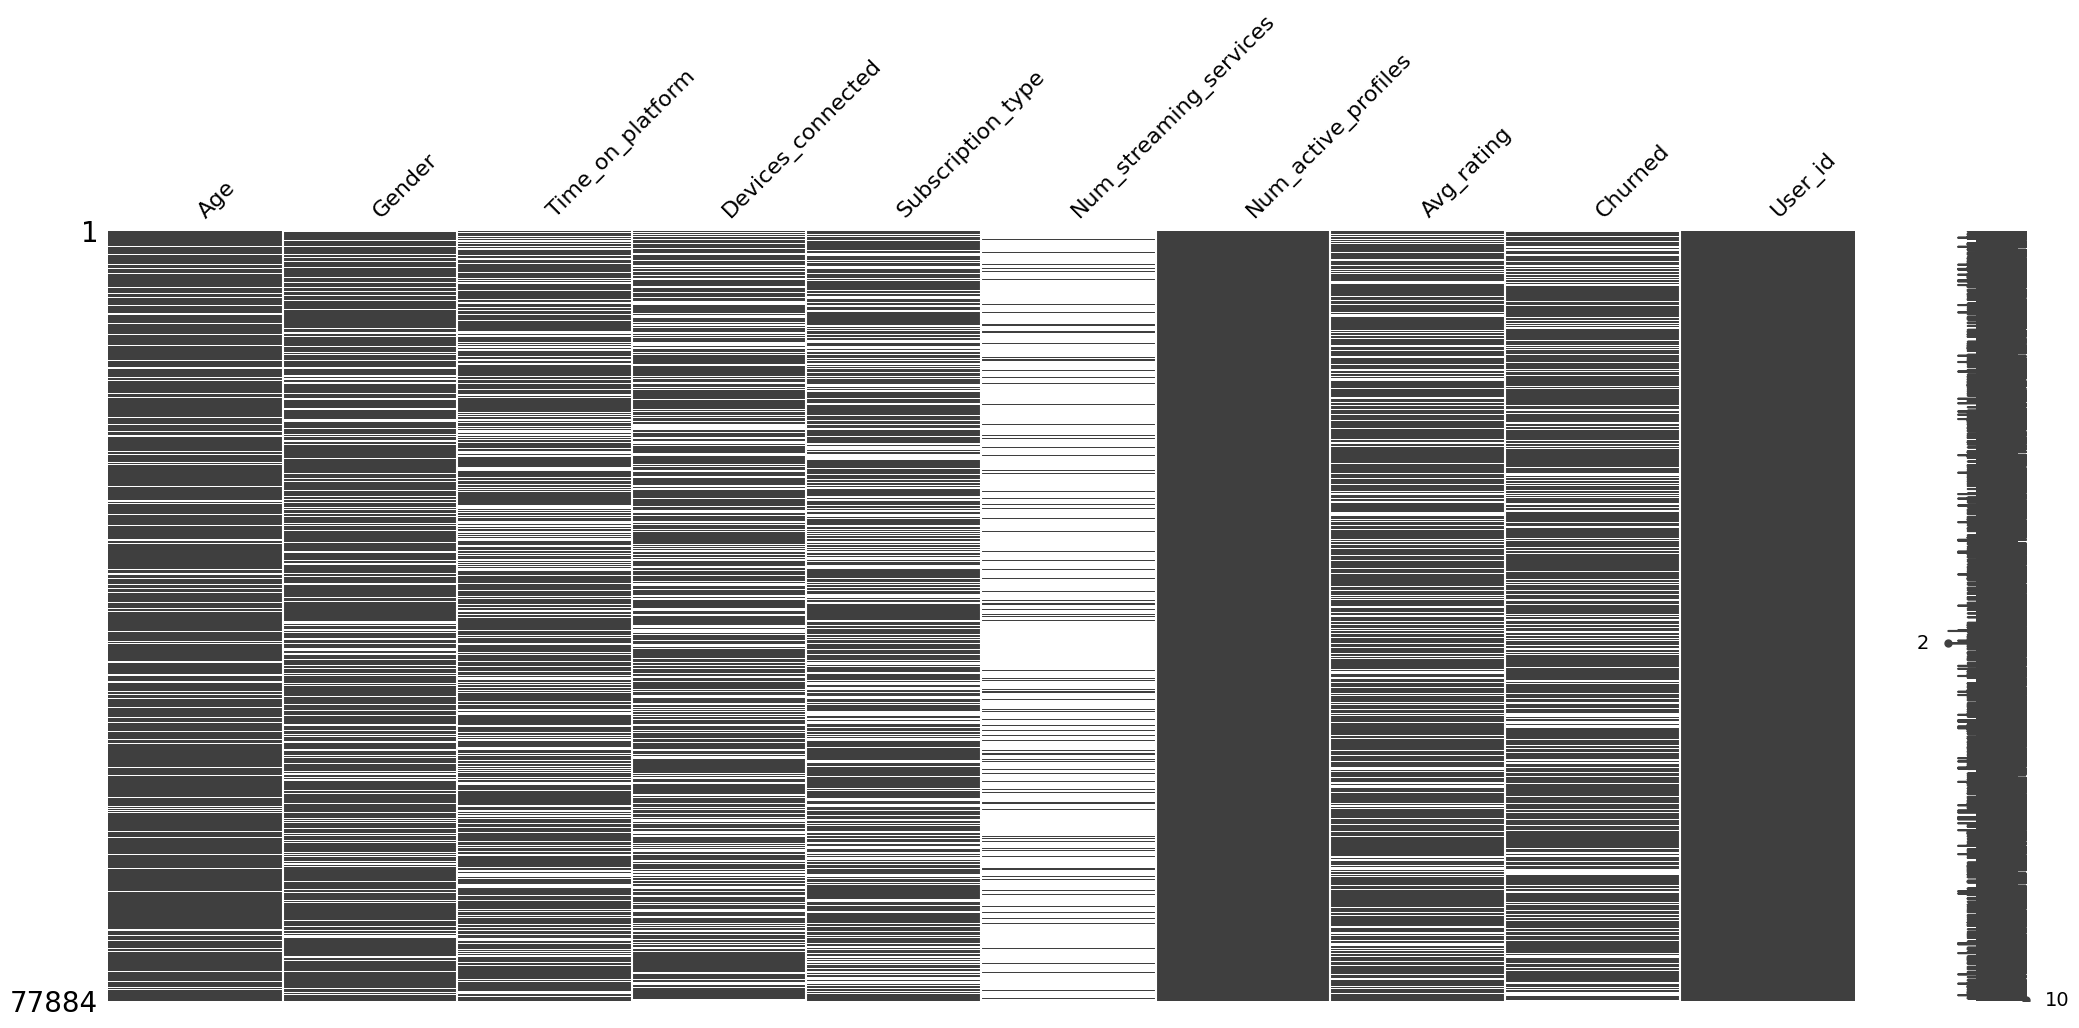

In [32]:
# Resumindo os dados que estão faltando, no formato de Gráfico
msno.matrix(df);

In [33]:
# Resumindo os dados que estão faltando, no formato de tabela
df.stb.missing()

,missing,total,percent
Num_streaming_services,68312,77884,87.709928
Subscription_type,25221,77884,32.382774
Devices_connected,25188,77884,32.340404
Time_on_platform,21420,77884,27.502440
Avg_rating,17270,77884,22.174002
Churned,16736,77884,21.488367
Gender,14516,77884,18.637974
Age,11277,77884,14.479226
Num_active_profiles,0,77884,0.000000
User_id,0,77884,0.000000


In [34]:
# Conforme designação do cliente, os dados faltantes serão preenchidos com zero, nas colunas abaixo:
df['Num_streaming_services'] = df['Num_streaming_services'].fillna(0)
df['Devices_connected'] = df['Devices_connected'].fillna(0)
df['Time_on_platform'] = df['Time_on_platform'].fillna(0)
df['Avg_rating'] = df['Avg_rating'].fillna(0)
df['Churned'] = df['Churned'].fillna(0)

df.dropna(subset=['Gender', 'Subscription_type', 'Age'], inplace=True)

df.stb.missing()

,missing,total,percent
Age,0,36515,0.0
Gender,0,36515,0.0
Time_on_platform,0,36515,0.0
Devices_connected,0,36515,0.0
Subscription_type,0,36515,0.0
Num_streaming_services,0,36515,0.0
Num_active_profiles,0,36515,0.0
Avg_rating,0,36515,0.0
Churned,0,36515,0.0
User_id,0,36515,0.0


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36515 entries, 0 to 77883
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     36515 non-null  float64
 1   Gender                  36515 non-null  object 
 2   Time_on_platform        36515 non-null  float64
 3   Devices_connected       36515 non-null  float64
 4   Subscription_type       36515 non-null  object 
 5   Num_streaming_services  36515 non-null  float64
 6   Num_active_profiles     36515 non-null  int64  
 7   Avg_rating              36515 non-null  float64
 8   Churned                 36515 non-null  float64
 9   User_id                 36515 non-null  object 
dtypes: float64(6), int64(1), object(3)
memory usage: 3.1+ MB


## Correção do tipo de dados

In [36]:
# ALTERANDO O FORMATO DOS DADOS
df['Churned'].replace({0: 'No', 1: 'Yes'}, inplace=True)
df['Churned'] = df['Churned'].astype(str)

df['Age'] = df['Age'].astype('int64')
df['Time_on_platform'] = df['Time_on_platform'].astype('int64')
df['Num_streaming_services'] = df['Num_streaming_services'].astype('int64')
df['Devices_connected'] = df['Devices_connected'].astype('int64')

df['Gender'] = df['Gender'].astype(str)
df['Subscription_type'] = df['Subscription_type'].astype(str)
df['User_id'] = df['User_id'].astype(str)


df.head()



,Age,Gender,Time_on_platform,Devices_connected,Subscription_type,Num_streaming_services,Num_active_profiles,Avg_rating,Churned,User_id
0,49,Male,4700,3,Basic,0,3,0.00,No,a271aa56-bcfc-4f0a-91f7-b773de6b86a4
1,69,Female,6107,2,Standard,0,1,2.14,No,fe14b048-770b-4619-8ec6-485b0969ae31
2,44,Male,6374,3,Premium,1,1,1.91,Yes,0283dffd-6684-4a05-9c6f-c02098a6849d
3,26,Male,0,5,Basic,0,2,0.00,No,c316f2f5-3403-4a0a-82c2-c98e4b3379d2
5,54,Male,3024,2,Basic,0,1,0.00,No,a1df3a13-9255-4d00-8a9d-20565fefaab9


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36515 entries, 0 to 77883
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     36515 non-null  int64  
 1   Gender                  36515 non-null  object 
 2   Time_on_platform        36515 non-null  int64  
 3   Devices_connected       36515 non-null  int64  
 4   Subscription_type       36515 non-null  object 
 5   Num_streaming_services  36515 non-null  int64  
 6   Num_active_profiles     36515 non-null  int64  
 7   Avg_rating              36515 non-null  float64
 8   Churned                 36515 non-null  object 
 9   User_id                 36515 non-null  object 
dtypes: float64(1), int64(5), object(4)
memory usage: 3.1+ MB



## *Dados Duplicados*
Remoção de dados dos dados duplicados, pois não tem sentido o mesmo cliente ser classificado de Churn, duas vezes. são cerca de 6000 dados.

In [38]:
# Identificar quantos valores duplicados há em cada duplicata
(
  df
 .groupby(df.columns.tolist(), dropna=False)
 .size()
 .to_frame('n_duplicates')
 .query('n_duplicates>1')
 .sort_values('n_duplicates', ascending=False)
 .head(100)
)


n_duplicates
Age Gender Time_on_platform Devices_connected Subscription_type Num_streaming_services Num_active_profiles Avg_rating Churned User_id                                           
18  Female 0                0                 Basic             0                      1                   0.00       No      1310f1e9-6308-468e-97ad-d60973085762             2
52  Female 4140             3                 Premium           0                      1                   1.80       No      e5f87380-64f0-4bdc-ad6a-d6bed48ce398             2
           2783             5                 Basic             0                      2                   3.91       No      dc6d65f3-668e-4fcf-800f-e0886a47a303             2
           2610             3                 Standard          0                      5                   2.84       No      dc978730-904f-44e3-a7d4-43ebdbb653f8             2
           2603             0                 Premium           0                      1                   3.17       No      8dc200d8-b865-472e-8b37-b7153f8b4e30             2
...                                                                                                                                                                          ...
53  Female 1631             2                 Premium           0                      2                   1.02       No      a8d0fb7d-72a4-4a09-b668-f5bbdc49a5c0             2
           1423             2                 Premium           0                      5                   2.20       No      e82fb485-3c4d-404a-a47f-6dac6969bcd8             2
           1398             5                 Standard          0                      5                   0.00       No      cd585f7c-aa58-4242-998c-c004bb19f4a6             2
           1266             1                 Basic             0                      4                   1.29       No      04e95309-3a96-4e71-bcd6-f8004bbc8209             2
           1081             1                 Standard          0                      2                   3.43       No      65438bb2-df12-41cf-ac53-cba5dbb35b89             2

[100 rows x 1 columns]

In [39]:
df = df.drop_duplicates(keep='first')
df.head()

,Age,Gender,Time_on_platform,Devices_connected,Subscription_type,Num_streaming_services,Num_active_profiles,Avg_rating,Churned,User_id
0,49,Male,4700,3,Basic,0,3,0.00,No,a271aa56-bcfc-4f0a-91f7-b773de6b86a4
1,69,Female,6107,2,Standard,0,1,2.14,No,fe14b048-770b-4619-8ec6-485b0969ae31
2,44,Male,6374,3,Premium,1,1,1.91,Yes,0283dffd-6684-4a05-9c6f-c02098a6849d
3,26,Male,0,5,Basic,0,2,0.00,No,c316f2f5-3403-4a0a-82c2-c98e4b3379d2
5,54,Male,3024,2,Basic,0,1,0.00,No,a1df3a13-9255-4d00-8a9d-20565fefaab9


# **ETAPA 4: MODELING**

# **ETAPA 5: EVALUATION**

# **ETAPA 6: DEPLOYMENT**